In [44]:
from dataloader.dataloader import DatasetLoader

from functions.calculate_mse_psnr import calculate_mse_psnr

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import copy
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau


from PIL import Image

import numpy as np

import matplotlib.pyplot as plt

import os
import scipy.io
from tqdm import tqdm
from models.CSMAE_test import CSMAE

In [45]:
device = "cpu"
nKernel = 16
model_folder_path = "./train_results/CSAEMatrix_16_0.1/25000_0.0001_1000_0.8"
phi_path = model_folder_path+"/phi_epoch.pt"
phi_mask_path = model_folder_path+"/phi_mask.pt"
wts_path = model_folder_path+"/best_model.pth"


cRatio = 0.1

phi = torch.load(phi_path)
phi_mask = torch.load(phi_mask_path)
wts = torch.load(wts_path)

model = CSMAE(output_size=(nKernel*nKernel),CR=cRatio,phi=phi,mask=phi_mask,pretrained_weights=wts).to(device)

In [47]:
transform = transforms.Compose([ # Ajusta al tamaño deseado
    transforms.ToTensor()
])

parche = Image.open(f"./imnist.png").convert("L")
parchet = transform(parche).to(device)

model.eval()

with torch.no_grad():
    parche_rec = model(parchet.view(1,1,-1)).cpu().squeeze().reshape(nKernel,nKernel)
    
parche_rec = (np.array(parche_rec)*255.0).astype(np.uint8)
parche_rec = Image.fromarray(parche_rec)

plt.subplot(1,2,1)
plt.imshow(parche)


plt.subplot(1,2,2)

plt.imshow(parche_rec)
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x372736 and 256x25)

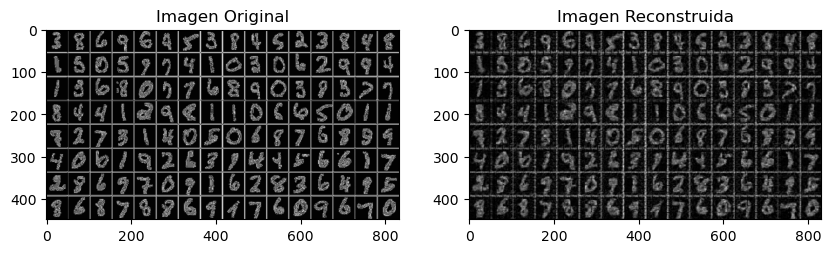

MSE : 1047.1774607228708 || PSNR : 17.930600749083162


In [48]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch

imageOG = Image.open("./imnist.png").convert("L")
transform = transforms.Compose([
    transforms.ToTensor(),
])
image = transform(imageOG)
patch_size = nKernel
num_patches_height = image.shape[1] // patch_size
num_patches_width = image.shape[2] // patch_size
reconstructed_image = torch.zeros((patch_size * num_patches_height, patch_size * num_patches_width))
all_inputs = []
for i in range(num_patches_height):
    for j in range(num_patches_width):
        patch = image[:, i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
        patch = patch.to(device).reshape(1, -1)
        input = patch
        all_inputs.append(input)
        with torch.no_grad():
            model.eval()
            patch_rec = torch.clamp(model(input).cpu().squeeze(),max=1,min=0)
        reconstructed_image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = patch_rec.reshape(patch_size, patch_size)
all_inputs_tensor = torch.stack(all_inputs)
reconstructed_image = (reconstructed_image * 255.0).clamp(0, 255).numpy().astype(np.uint8)
reconstructed_image = Image.fromarray(reconstructed_image)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(imageOG, cmap='gray')
plt.title('Imagen Original')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Imagen Reconstruida')
plt.show()
mse,psnr = calculate_mse_psnr(imageOG,reconstructed_image)
print(f"MSE : {mse} || PSNR : {psnr}")


In [49]:
reconstructed_image.save('B.png')

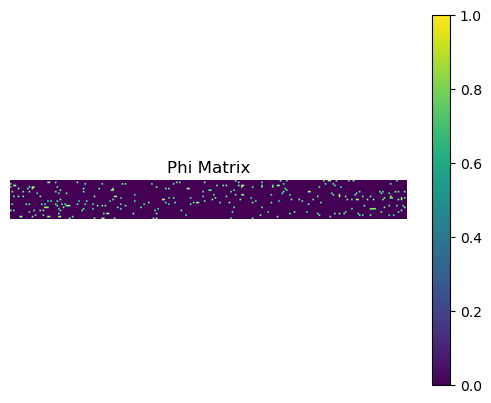

In [43]:

phi_image_np =(np.array(phi.cpu()))
phi_image = (phi_image_np)
phi_image = Image.fromarray(phi_image).convert("L")
plt.imshow(phi_image)
plt.title("Phi Matrix")
plt.axis("off")
plt.savefig("phi_matrix_mask")
plt.colorbar()
plt.show()



In [125]:
cantidad_ceros = np.count_nonzero(phi_image_np[2,:] == 0)

print("Cantidad de ceros en la matriz:", cantidad_ceros)

Cantidad de ceros en la matriz: 233


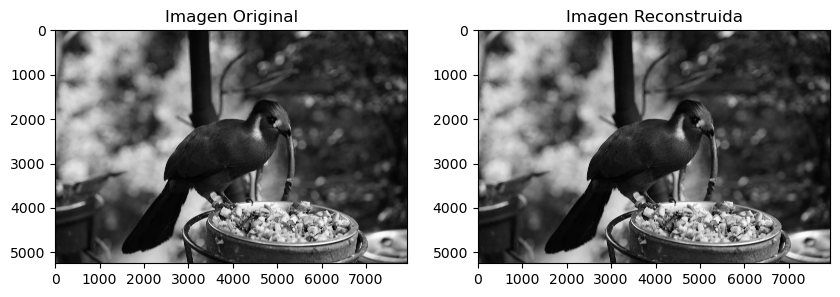

MSE : 0.5408032985300084 || PSNR : 50.80041029027133


In [33]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch

# Asumiendo que 'model' es una instancia de CSMAE y 'device' es tu dispositivo de cómputo (por ejemplo, 'cuda' o 'cpu')

imageOG = Image.open("./B.png").convert("L")
transform = transforms.Compose([
    transforms.ToTensor(),
])
image = transform(imageOG)
patch_size = nKernel  # Asegúrate de definir nKernel
num_patches_height = image.shape[1] // patch_size
num_patches_width = image.shape[2] // patch_size
reconstructed_image = torch.zeros((patch_size * num_patches_height, patch_size * num_patches_width))
encoded_output_size = int(patch_size * patch_size * cRatio)  # Asegúrate de definir CR

# Pre-asignar memoria para todos los parches codificados
all_encoded_outputs = torch.zeros((num_patches_height * num_patches_width, encoded_output_size))

for i in range(num_patches_height):
    for j in range(num_patches_width):
        patch = image[:, i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
        patch = patch.to(device).reshape(1, -1)

        with torch.no_grad():
            model.eval()
            # Utiliza el codificador y el decodificador por separado
            encoded_output = model.encoder(patch)
            # Almacena la salida codificada en el tensor pre-asignado
            all_encoded_outputs[i * num_patches_width + j] = encoded_output.squeeze()
            patch_rec = model.decoder(encoded_output).cpu().squeeze()

        reconstructed_image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = patch_rec.reshape(patch_size, patch_size)

reconstructed_image = (reconstructed_image * 255.0).clamp(0, 255).numpy().astype(np.uint8)
reconstructed_image = Image.fromarray(reconstructed_image)

# Mostrar las imágenes
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(imageOG, cmap='gray')
plt.title('Imagen Original')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Imagen Reconstruida')
plt.show()

mse, psnr = calculate_mse_psnr(imageOG, reconstructed_image)
print(f"MSE : {mse} || PSNR : {psnr}")


In [34]:
all_encoded_outputs_np = all_encoded_outputs.numpy()
# Guardar el array en un archivo .mat
scipy.io.savemat('b.mat', {'b': all_encoded_outputs_np})

In [109]:
from PIL import Image
from torchvision import transforms
import numpy as np
import torch
import os
import glob

# Asumiendo que 'model' es una instancia de CSMAE y 'device' es tu dispositivo de cómputo (por ejemplo, 'cuda' o 'cpu')

input_folder = "./dataset/standard_Images/"  # Ruta de la carpeta con las imágenes originales
output_folder = "./dataset/im16"  # Ruta de la carpeta de salida
patch_size = nKernel  # Asegúrate de definir nKernel
cRatio = 0.1  # Asegúrate de definir CR

transform = transforms.Compose([transforms.ToTensor()])

# Crear la carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

# Obtener una lista de archivos de imagen en la carpeta de entrada
image_files = glob.glob(os.path.join(input_folder, "*.png"))  # Ajusta la extensión si es necesario

for image_file in image_files:
    imageOG = Image.open(image_file).convert("L")
    image = transform(imageOG)

    num_patches_height = image.shape[1] // patch_size
    num_patches_width = image.shape[2] // patch_size
    reconstructed_image = torch.zeros((patch_size * num_patches_height, patch_size * num_patches_width))
    encoded_output_size = int(patch_size * patch_size * cRatio)

    # Procesar la imagen
    for i in range(num_patches_height):
        for j in range(num_patches_width):
            patch = image[:, i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
            patch = patch.to(device).reshape(1, -1)

            with torch.no_grad():
                model.eval()
                encoded_output = model.encoder(patch)
                patch_rec = model.decoder(encoded_output).cpu().squeeze()

            reconstructed_image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = patch_rec.reshape(patch_size, patch_size)

    reconstructed_image_np = (reconstructed_image * 255.0).clamp(0, 255).numpy().astype(np.uint8)
    reconstructed_image_pil = Image.fromarray(reconstructed_image_np)

    # Guardar la imagen reconstruida con el mismo nombre de la imagen original
    image_name = os.path.basename(image_file)  # Usa el nombre de la imagen original
    reconstructed_image_pil.save(os.path.join(output_folder, image_name))

    # Opcional: Imprimir el progreso

    # Opcional: Calcular y mostrar MSE y PSNR
    # mse, psnr = calculate_mse_psnr(imageOG, reconstructed_image_pil)
    # print(f"MSE : {mse} || PSNR : {psnr}")
